In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Reference
https://www.kaggle.com/sterby/fasttext-like-baseline-with-keras-lb-0-056 

https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051/code

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [2]:
dataset = pd.read_csv('./train.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95851 entries, 0 to 95850
Data columns (total 8 columns):
id               95851 non-null int64
comment_text     95851 non-null object
toxic            95851 non-null int64
severe_toxic     95851 non-null int64
obscene          95851 non-null int64
threat           95851 non-null int64
insult           95851 non-null int64
identity_hate    95851 non-null int64
dtypes: int64(7), object(1)
memory usage: 5.9+ MB


In [4]:
dataset.head()

id                                       comment_text  toxic  \
0  22256635  Nonsense?  kiss off, geek. what I said is true...      1   
1  27450690  "\n\n Please do not vandalize pages, as you di...      0   
2  54037174  "\n\n ""Points of interest"" \n\nI removed the...      0   
3  77493077  Asking some his nationality is a Racial offenc...      0   
4  79357270  The reader here is not going by my say so for ...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

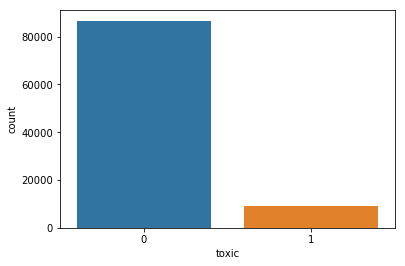

In [5]:
sns.countplot(dataset.toxic)

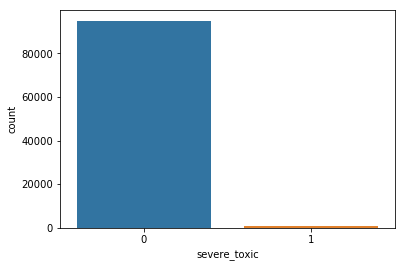

In [6]:
sns.countplot(dataset.severe_toxic)

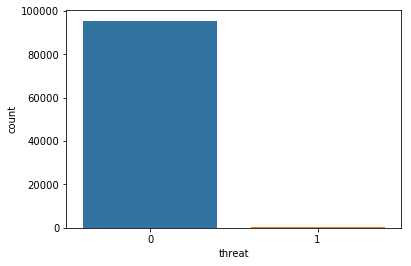

In [7]:
sns.countplot(dataset.threat)

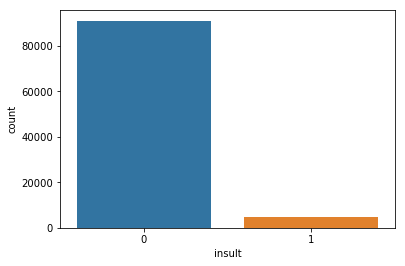

In [8]:
sns.countplot(dataset.insult)

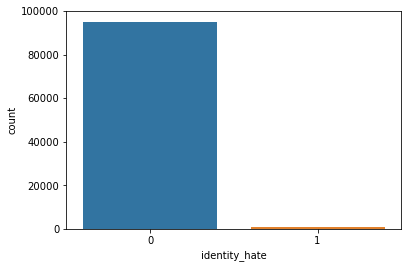

In [9]:
sns.countplot(dataset.identity_hate)

In [10]:
len([x for x in dataset.iloc[:,[2,3,4,5,6,7]].sum(axis=1).tolist() if x!=0])*100/len(dataset)

dataset['good'] = [1 if x==0 else 0 for x in dataset.iloc[:,[2,3,4,5,6,7]].sum(axis=1).tolist() ]

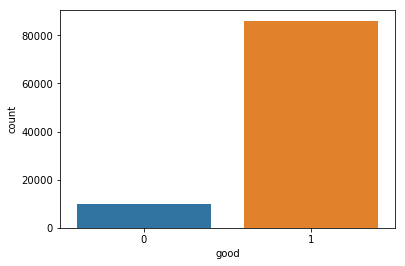

In [11]:
sns.countplot(dataset.good)

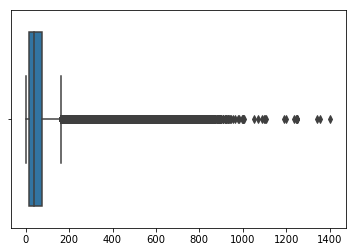

In [12]:
wordcounts = [len(x.split()) for x in dataset.comment_text]
max_comment_length = max(wordcounts)
sns.boxplot(wordcounts)

In [13]:
dataset.head()

id                                       comment_text  toxic  \
0  22256635  Nonsense?  kiss off, geek. what I said is true...      1   
1  27450690  "\n\n Please do not vandalize pages, as you di...      0   
2  54037174  "\n\n ""Points of interest"" \n\nI removed the...      0   
3  77493077  Asking some his nationality is a Racial offenc...      0   
4  79357270  The reader here is not going by my say so for ...      0   

   severe_toxic  obscene  threat  insult  identity_hate  good  
0             0        0       0       0              0     0  
1             0        0       0       0              0     1  
2             0        0       0       0              0     1  
3             0        0       0       0              0     1  
4             0        0       0       0              0     1

In [14]:
X = dataset.comment_text
y = dataset.iloc[:,[2,3,4,5,6,7,8]]

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
print(X[0])
proc_text = text_to_word_sequence(X[0],filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
# stopwords
# [word for word in proc_text if word not in stop_words]
print(proc_text)

Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated.
['nonsense', 'kiss', 'off', 'geek', 'what', 'i', 'said', 'is', 'true', "i'll", 'have', 'your', 'account', 'terminated']


In [17]:
comments = []
word_counter = Counter()

for comment in dataset.comment_text:
    proc_text = text_to_word_sequence(comment, filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
    # proc_text = [word for word in proc_text if word not in stop_words]
    word_counter.update(proc_text)
    comments.append(proc_text)

In [18]:
word_to_int = dict((word, key) for key, word in zip(range(len(word_counter)),word_counter))
print(word_to_int.get('cranborne',-1))

63909


In [19]:
X_ints = [[word_to_int.get(word) for word in words] for words in comments]
max_comment_length = max([len(words) for words in comments])
print(max_comment_length)

1403


In [20]:
maxlen = 200
X_sequence = sequence.pad_sequences(X_ints, maxlen = maxlen)
X_sequence = np.array(X_sequence)
y = np.array(y)
print(X_sequence.shape)
print(y.shape)

(95851, 200)
(95851, 7)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(76680, 200)
(19171, 200)
(76680, 7)
(19171, 7)


In [27]:
embed_lenth = 128
max_features = 20000
batch_size = 32

rnn = Sequential()
rnn.add(Embedding(max_features, embed_lenth, input_length=X_sequence.shape[1]))
rnn.add(LSTM(128))
rnn.add(Dense(y.shape[1], activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
filepath = './best_model.hdf5'

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'), 
             ModelCheckpoint(filepath=filepath, monitor='loss', mode='auto', verbose=0)]
rnn.fit(X_train, y_train, epochs=100, verbose=1, batch_size=batch_size, validation_data=(X_test, y_test))

Train on 76680 samples, validate on 19171 samples
Epoch 1/100
76680/76680 [==============================] - 726s - loss: 0.7380 - acc: 0.9037 - val_loss: 0.6602 - val_acc: 0.9237

In [29]:
rnn.save(filepath)

In [25]:
rnn.load_weights(filepath)

In [30]:
dataset_sub = pd.read_csv('./test.csv')
dataset_sub.head()

id                                       comment_text
0   6044863  ==Orphaned non-free media (Image:41cD1jboEvL. ...
1   6102620  ::Kentuckiana is colloquial.  Even though the ...
2  14563293  Hello fellow Wikipedians,\nI have just modifie...
3  21086297  AKC Suspensions \nThe Morning Call - Feb 24, 2...
4  22982444                      == [WIKI_LINK: Talk:Celts] ==

In [34]:
dataset_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226998 entries, 0 to 226997
Data columns (total 2 columns):
id              226998 non-null int64
comment_text    226997 non-null object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [36]:
comments_sub = []

for comment in dataset_sub.comment_text:
    # print(comment)
    proc_text = text_to_word_sequence(str(comment), filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
    # proc_text = [word for word in proc_text if word not in stop_words]
    comments_sub.append(proc_text)

In [37]:
X_sub_ints = [[word_to_int.get(word, -1) for word in words] for words in comments_sub]
X_sub_sequence = sequence.pad_sequences(X_sub_ints, maxlen = maxlen)
X_sub_sequence = np.array(X_sub_sequence)
print(X_sub_sequence.shape)

(95851, 7)


In [40]:
preds = rnn.predict(X_sub_sequence, verbose=True)

226998/226998 [==============================] - 454s     

In [43]:
preds[:,0:5]

array([[  2.32504385e-06,   1.82088979e-11,   6.15930674e-07,
          1.19623039e-17,   4.13107188e-07],
       [  1.15915624e-10,   3.62017707e-13,   4.91656230e-11,
          1.00590448e-13,   4.84841334e-11],
       [  2.41140267e-12,   1.17297308e-16,   5.78230118e-13,
          1.33571110e-21,   4.80057725e-13],
       ..., 
       [  2.11337721e-07,   1.16391391e-12,   4.49802720e-08,
          3.97415274e-20,   3.42428237e-08],
       [  5.98192074e-08,   1.92289639e-13,   1.02050510e-08,
          6.31276016e-19,   5.66022962e-09],
       [  2.89214377e-12,   3.30364343e-16,   8.04057342e-13,
          6.19595243e-19,   5.67328519e-13]], dtype=float32)

In [54]:
submission = pd.DataFrame({'id':dataset_sub.id.apply(str)})

In [46]:
dataset.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'good'],
      dtype='object')

In [55]:
submission['toxic'] = preds[:,0]
submission['severe_toxic'] = preds[:,1]
submission['obscene'] = preds[:,2]
submission['threat'] = preds[:,3]
submission['insult'] = preds[:,4]
submission['identity_hate'] = preds[:,5]
submission.head()

id         toxic  severe_toxic       obscene        threat  \
0   6044863  2.325044e-06  1.820890e-11  6.159307e-07  1.196230e-17   
1   6102620  1.159156e-10  3.620177e-13  4.916562e-11  1.005904e-13   
2  14563293  2.411403e-12  1.172973e-16  5.782301e-13  1.335711e-21   
3  21086297  7.626567e-10  3.610210e-11  3.645411e-10  3.110225e-11   
4  22982444  5.167547e-09  2.796468e-10  2.787321e-09  2.854822e-11   

         insult  identity_hate  
0  4.131072e-07   5.381431e-12  
1  4.848413e-11   2.221293e-12  
2  4.800577e-13   1.260727e-16  
3  3.950623e-10   5.127992e-11  
4  2.626794e-09   1.569068e-10

In [56]:
submission.to_csv('./submission_lstm.csv', sep=',', encoding='utf-8', index=False)